In [144]:
import pandas as pd
import seaborn as sns


# Read the data in

In [145]:
coh_data_df = pd.read_excel('../datasets/DAPL - DAT - 6 Cohort Analysis.xlsx',
                                sheet_name='DataSet2')
coh_data_df

,Unnamed: 0,CustID,CustCat,DateStart,DateLastPurchase
0,NaN,1,S,2020-01-01 05:50:05,2020-02-27 00:00:18
1,NaN,2,M,2020-01-02 05:50:05,2020-02-27 00:00:18
2,NaN,3,S,2020-01-03 07:47:23,2020-04-13 08:36:57
3,NaN,4,S,2020-01-03 08:02:00,2020-07-18 05:06:03
4,NaN,5,S,2020-01-04 07:35:53,2020-03-18 21:59:25
...,...,...,...,...,...
4130,NaN,4131,M,2020-12-31 02:30:35,2021-07-12 17:17:28
4131,NaN,4132,L,2020-12-31 02:34:54,2021-09-24 22:40:18
4132,NaN,4133,S,2020-12-31 04:24:19,2021-06-06 17:17:39
4133,NaN,4134,M,2020-12-31 04:40:51,2021-05-17 21:36:56


In [146]:
coh_data_df.dtypes

Unnamed: 0                 float64
CustID                       int64
CustCat                     object
DateStart           datetime64[ns]
DateLastPurchase    datetime64[ns]
dtype: object

# Prep the data

In [147]:

coh_data_df["startdate"] = coh_data_df.apply(lambda row: row['DateStart'].date(), axis=1)

coh_data_df["lastdate"] = coh_data_df.apply(lambda row: row['DateLastPurchase'].date(), axis=1)
coh_data_df["activedays"] = (coh_data_df['lastdate'] - coh_data_df['startdate']).dt.days
coh_data_df["retentionmonths"] = round(coh_data_df["activedays"]/30)
coh_data_df["startmonth"] =  coh_data_df.apply(lambda row: row['startdate'].month, axis=1)
coh_data_df["lastactivitymonth"] =  coh_data_df.apply(lambda row: row['lastdate'].month, axis=1) 

In [148]:
df =  coh_data_df[["CustID","startdate","startmonth","lastdate","activedays"]]
df['startdate']= pd.to_datetime(df['startdate'])
df['lastdate']= pd.to_datetime(df['lastdate'])
df['cohort'] = df.groupby('CustID')['startdate'] \
                 .transform('min') \
                 .dt.to_period('M') 
df['last_active_month'] = df['lastdate'].dt.to_period('M')

<ipython-input-148-04c7fb3a8d55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['startdate']= pd.to_datetime(df['startdate'])
<ipython-input-148-04c7fb3a8d55>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lastdate']= pd.to_datetime(df['lastdate'])
<ipython-input-148-04c7fb3a8d55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [149]:
df

,CustID,startdate,startmonth,lastdate,activedays,cohort,last_active_month
0,1,2020-01-01,1,2020-02-27,57,2020-01,2020-02
1,2,2020-01-02,1,2020-02-27,56,2020-01,2020-02
2,3,2020-01-03,1,2020-04-13,101,2020-01,2020-04
3,4,2020-01-03,1,2020-07-18,197,2020-01,2020-07
4,5,2020-01-04,1,2020-03-18,74,2020-01,2020-03
...,...,...,...,...,...,...,...
4130,4131,2020-12-31,12,2021-07-12,193,2020-12,2021-07
4131,4132,2020-12-31,12,2021-09-24,267,2020-12,2021-09
4132,4133,2020-12-31,12,2021-06-06,157,2020-12,2021-06
4133,4134,2020-12-31,12,2021-05-17,137,2020-12,2021-05


In [150]:
from operator import attrgetter
df_cohort = df.groupby(['cohort', 'last_active_month']) \
              .agg(n_customers=('CustID', 'nunique')) \
              .reset_index(drop=False)

df_cohort2 = df.groupby(['cohort']) \
              .agg(n_customers=('CustID', 'nunique')) \
              .reset_index(drop=False)
df_cohort2.rename(columns = {'n_customers':'total_customers'},inplace=True)

df_cohort3 = df_cohort.merge(df_cohort2, on = 'cohort', how = 'left')
df_cohort3['ndropped_cust'] =  df_cohort3.groupby(['cohort'])['n_customers'].apply(lambda x: x.cumsum()) 
df_cohort3["retained_customers"] = df_cohort3["total_customers"] - df_cohort3["ndropped_cust"]
df_cohort3['retained_months'] = (df_cohort3.last_active_month - df_cohort3.cohort).apply(attrgetter('n'))
df_cohort3["retained_months"].unique()

<ipython-input-150-22e2e0407d46>:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_cohort3['ndropped_cust'] =  df_cohort3.groupby(['cohort'])['n_customers'].apply(lambda x: x.cumsum())


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0, 12])

In [151]:
df_cohort3[df_cohort3['cohort'] == '2020-12']

,cohort,last_active_month,n_customers,total_customers,ndropped_cust,retained_customers,retained_months
133,2020-12,2020-12,14,356,14,342,0
134,2020-12,2021-01,17,356,31,325,1
135,2020-12,2021-02,28,356,59,297,2
136,2020-12,2021-03,20,356,79,277,3
137,2020-12,2021-04,29,356,108,248,4
138,2020-12,2021-05,59,356,167,189,5
139,2020-12,2021-06,25,356,192,164,6
140,2020-12,2021-07,36,356,228,128,7
141,2020-12,2021-08,27,356,255,101,8
142,2020-12,2021-09,36,356,291,65,9


In [152]:
df_cohort3

,cohort,last_active_month,n_customers,total_customers,ndropped_cust,retained_customers,retained_months
0,2020-01,2020-02,30,194,30,164,1
1,2020-01,2020-03,27,194,57,137,2
2,2020-01,2020-04,19,194,76,118,3
3,2020-01,2020-05,10,194,86,108,4
4,2020-01,2020-06,12,194,98,96,5
...,...,...,...,...,...,...,...
141,2020-12,2021-08,27,356,255,101,8
142,2020-12,2021-09,36,356,291,65,9
143,2020-12,2021-10,34,356,325,31,10
144,2020-12,2021-11,23,356,348,8,11


In [153]:
df_for_pivot = df_cohort3[["cohort","retained_months","retained_customers"]]
cohorts = df_for_pivot["cohort"].unique()
for cohort in cohorts:
    intital_total_cust = df_cohort2[df_cohort2["cohort"] == cohort]["total_customers"].values[0]
    tempdf = df_for_pivot[df_for_pivot["cohort"] == cohort]
    retainedmonths = tempdf["retained_months"].unique()
    if 0 not in retainedmonths:
        print("appending for cohort",cohort)
        dfrow = {'cohort': cohort, 'retained_months': 0, 'retained_customers': intital_total_cust}
        df_for_pivot = df_for_pivot.append(dfrow,ignore_index = True )
df_for_pivot = df_for_pivot[df_for_pivot["retained_months"] <= 10]

appending for cohort 2020-01


<ipython-input-153-345c036446bd>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_for_pivot = df_for_pivot.append(dfrow,ignore_index = True )


In [154]:
df_for_pivot[df_for_pivot["cohort"] == '2020-01']

,cohort,retained_months,retained_customers
0,2020-01,1,164
1,2020-01,2,137
2,2020-01,3,118
3,2020-01,4,108
4,2020-01,5,96
5,2020-01,6,81
6,2020-01,7,64
7,2020-01,8,46
8,2020-01,9,29
9,2020-01,10,10


# do the pivot to create retention table

In [155]:
cohort_pivot = df_for_pivot.pivot_table(index = 'cohort',
                                     columns = 'retained_months',
                                     values = 'retained_customers',
                                    aggfunc='sum')

In [156]:
cohort_pivot

retained_months,0,1,2,3,4,5,6,7,8,9,10
cohort,,,,,,,,,,,
2020-01,194,164,137,118,108,96,81,64,46,29,10
2020-02,338,292,257,223,199,161,133,107,79,47,17
2020-03,355,308,252,226,196,164,129,95,71,39,17
2020-04,371,253,241,237,216,187,135,107,74,39,11
2020-05,317,263,239,216,189,155,132,102,70,44,14
2020-06,287,256,233,207,168,155,140,117,80,43,10
2020-07,352,328,320,303,262,214,161,117,82,42,21
2020-08,366,348,325,292,242,210,172,123,91,49,16
2020-09,346,320,271,232,193,156,124,102,76,40,6


In [158]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [159]:
cohort_size

cohort
2020-01    194
2020-02    338
2020-03    355
2020-04    371
2020-05    317
2020-06    287
2020-07    352
2020-08    366
2020-09    346
2020-10    349
2020-11    266
2020-12    342
Freq: M, Name: 0, dtype: int64

In [160]:
retention_matrix

retained_months,0,1,2,3,4,5,6,7,8,9,10
cohort,,,,,,,,,,,
2020-01,1.0,0.845361,0.706186,0.608247,0.556701,0.494845,0.417526,0.329897,0.237113,0.149485,0.051546
2020-02,1.0,0.863905,0.760355,0.659763,0.588757,0.476331,0.393491,0.316568,0.233728,0.139053,0.050296
2020-03,1.0,0.867606,0.709859,0.636620,0.552113,0.461972,0.363380,0.267606,0.200000,0.109859,0.047887
2020-04,1.0,0.681941,0.649596,0.638814,0.582210,0.504043,0.363881,0.288410,0.199461,0.105121,0.029650
2020-05,1.0,0.829653,0.753943,0.681388,0.596215,0.488959,0.416404,0.321767,0.220820,0.138801,0.044164
2020-06,1.0,0.891986,0.811847,0.721254,0.585366,0.540070,0.487805,0.407666,0.278746,0.149826,0.034843
2020-07,1.0,0.931818,0.909091,0.860795,0.744318,0.607955,0.457386,0.332386,0.232955,0.119318,0.059659
2020-08,1.0,0.950820,0.887978,0.797814,0.661202,0.573770,0.469945,0.336066,0.248634,0.133880,0.043716
2020-09,1.0,0.924855,0.783237,0.670520,0.557803,0.450867,0.358382,0.294798,0.219653,0.115607,0.017341


# plot the cohort retention matrix

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import numpy as np

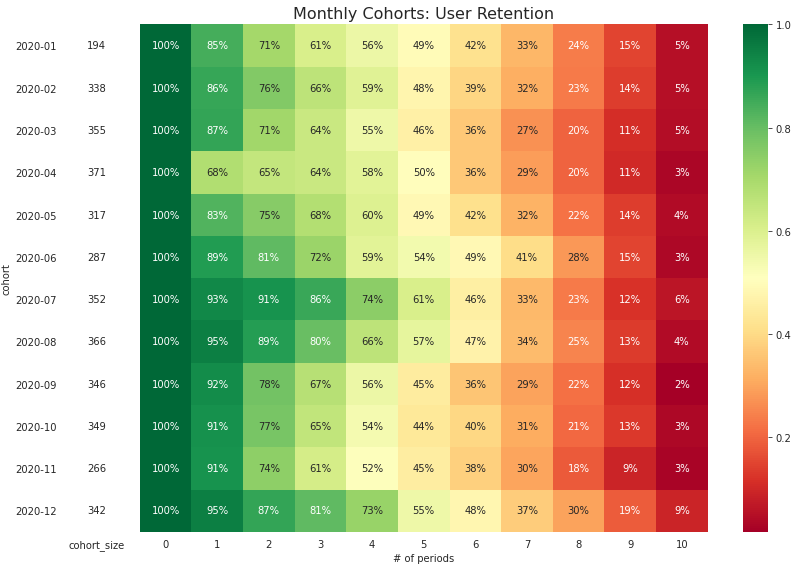

In [162]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()